# Prediction with Ridge-Regression

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [182]:
pred_data = pd.read_csv("prediction_ready.csv",parse_dates=["start_time"])
pred_data.head(1)

,start_time,month,day,hour,mean_duration,max_temp,precip,trips,isWeekday
0,2016-01-01,1.0,1.0,0.0,13.2,-4.4,0.0,25,0


In [183]:
#pick features
X_unscaled = pred_data[["month","hour","max_temp","precip","isWeekday"]]
y = pred_data["trips"].values.reshape([-1,1])

In [184]:
#scale data
scaler = StandardScaler()
X = scaler.fit_transform(X_unscaled)

In [185]:
#split into training (50%), verification (20%) and test (30%) set
X_train, X_test_meta, y_train, y_test_meta = train_test_split(X, y, test_size=0.5, random_state=0)
X_verification, X_test, y_verification, y_test = train_test_split(X_test_meta,y_test_meta, test_size=0.6, random_state=0)
pred_data["trips"].describe()

count    8784.000000
mean      407.050546
std       494.204738
min         0.000000
25%        39.000000
50%       202.000000
75%       616.000000
max      5110.000000
Name: trips, dtype: float64

In [186]:
# define Ridge-regression with polynomial features
def ridge(X,y,d,a):
    #create features
    PF = PolynomialFeatures(degree = d,interaction_only = False, include_bias = True)
    X_poly = PF.fit_transform(X)
    # create regression
    regression = Ridge(alpha = a, normalize = False, solver = 'lsqr')
    #fit
    regression.fit(X_poly,y)
    return regression, PF

In [187]:
# testrun regression
regression, PF = ridge(X_train,y_train,1,0)
X_test_poly = PF.transform(X_test)
print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 200737.4375519134
MAE: 319.9440844614896
R^2: 0.2026340718955959


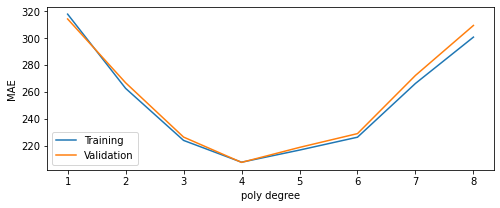

In [188]:
#get optimal hyperparameters from verification set
r_squ_train = []
r_squ_verification = []
mae_verification = []
mae_train = []

degree_space = np.linspace(1,8,8)
for degree in degree_space:
    regression, PF = ridge(X_train,y_train,int(degree),0)
    X_verification_poly = PF.transform(X_verification)
    
    r_squ_train.append(r2_score(y_train,regression.predict(PF.transform(X_train))))
    r_squ_verification.append(r2_score(y_verification,regression.predict(X_verification_poly)))

    mae_train.append(mean_absolute_error(y_train,regression.predict(PF.transform(X_train))))
    mae_verification.append(mean_absolute_error(y_verification,regression.predict(X_verification_poly)))
    
plt.figure(figsize = (8,3))
plt.plot(degree_space, mae_train)
plt.plot(degree_space, mae_verification)
plt.legend(["Training", "Validation"])
plt.xlabel("poly degree")
plt.ylabel("MAE")
plt.show()

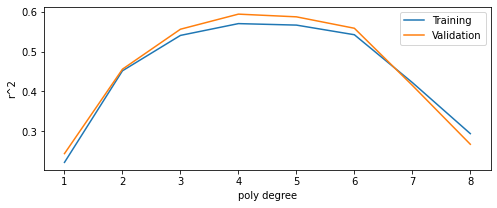

In [189]:
#plot r^2 for degree selection
plt.figure(figsize = (8,3))
plt.plot(degree_space, r_squ_train)
plt.plot(degree_space, r_squ_verification)
plt.legend(["Training", "Validation"])
plt.xlabel("poly degree")
plt.ylabel("r^2")
plt.show()

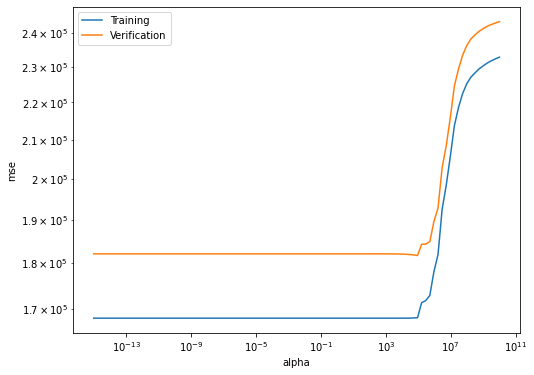

In [190]:
# find optimal alpha value
a_r_squ_train = []
a_r_squ_verification = []
a_mse_verification = []
a_mse_train = []

alpha_space = np.logspace(-15,10,100)

for alpha in alpha_space:
    regression, PF = ridge(X_train,y_train,8,alpha)
    X_verification_poly = PF.transform(X_verification)
    
    a_r_squ_train.append(r2_score(y_train,regression.predict(PF.transform(X_train))))
    a_r_squ_verification.append(r2_score(y_verification,regression.predict(X_verification_poly)))

    a_mse_train.append(mean_squared_error(y_train,regression.predict(PF.transform(X_train))))
    a_mse_verification.append(mean_squared_error(y_verification,regression.predict(X_verification_poly)))
    
plt.figure(figsize = (8,6))
plt.xscale("log")
plt.yscale("log")
plt.plot(alpha_space, a_mse_train)
plt.plot(alpha_space, a_mse_verification)
plt.legend(["Training", "Verification"])
plt.xlabel("alpha")
plt.ylabel("mse")
plt.show()

In [191]:
#get alpha at minimum
val, idx = min((val, idx) for (idx, val) in enumerate(a_mse_verification))
print("Minimum MSE: "+str(val), "At position: "+str(idx))
print("Alpha: "+str(np.logspace(-15,10,100)[79]))

Minimum MSE: 181662.94995017088 At position: 79
Alpha: 89021.5085445043


In [192]:
# choosen hyperparameters
regression, PF = ridge(X_train,y_train,8,89021.5085445043)
X_verification_poly = PF.transform(X_verification)
print("MSE: "+str(mean_squared_error(y_verification,regression.predict(X_verification_poly))))
print("MAE: "+str(mean_absolute_error(y_verification,regression.predict(X_verification_poly))))
print("R^2: "+ str(r2_score(y_verification,regression.predict(X_verification_poly))))

MSE: 181662.94995017088
MAE: 308.515378695733
R^2: 0.2688982682754384


In [193]:
# compare to poly
regression, PF = ridge(X_train,y_train,4,0)
X_verification_poly = PF.transform(X_verification)
print("MSE: "+str(mean_squared_error(y_verification,regression.predict(X_verification_poly))))
print("MAE: "+str(mean_absolute_error(y_verification,regression.predict(X_verification_poly))))
print("R^2: "+ str(r2_score(y_verification,regression.predict(X_verification_poly))))

MSE: 100790.43801046284
MAE: 207.4761574678765
R^2: 0.5943693318261172


### Test day feature

In [196]:
#pick features (with day feature)
X_unscaled = pred_data[["month","hour","day","max_temp","precip","isWeekday"]]
y = pred_data["trips"].values.reshape([-1,1])

In [197]:
#scale data (with day feature)
scaler = StandardScaler()
day_X = scaler.fit_transform(X_unscaled)

In [198]:
#split into training (50%), verification (20%) and test (30%) set (with day feature)
day_X_train, day_X_test_meta, day_y_train, day_y_test_meta = train_test_split(day_X, y, test_size=0.5, random_state=0)
day_X_verification, day_X_test, day_y_verification, day_y_test = train_test_split(day_X_test_meta,day_y_test_meta, test_size=0.6, random_state=0)

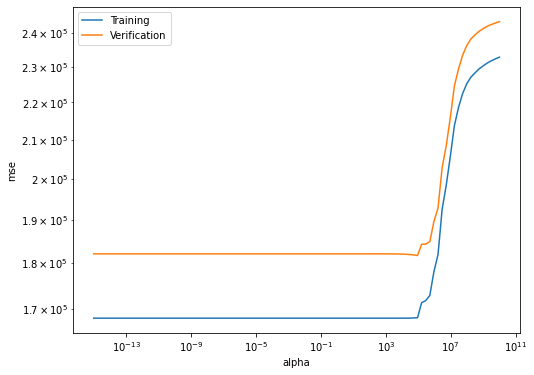

In [203]:
#determine alpha (with day feature)
day_r_squ_train = []
day_r_squ_verification = []
day_mse_verification = []
day_mse_train = []

day_alpha_space = np.logspace(-15,10,100)
for alpha in day_alpha_space:
    regression, PF = ridge(day_X_train,day_y_train,8,alpha)
    day_X_verification_poly = PF.transform(day_X_verification)
    
    day_r_squ_train.append(r2_score(day_y_train,regression.predict(PF.transform(day_X_train))))
    day_r_squ_verification.append(r2_score(day_y_verification,regression.predict(day_X_verification_poly)))

    day_mse_train.append(mean_squared_error(day_y_train,regression.predict(PF.transform(day_X_train))))
    day_mse_verification.append(mean_squared_error(day_y_verification,regression.predict(day_X_verification_poly)))

plt.figure(figsize = (8,6))
plt.xscale("log")
plt.yscale("log")
plt.plot(day_alpha_space, day_mse_train)
plt.plot(day_alpha_space, day_mse_verification)
plt.legend(["Training", "Verification"])
plt.xlabel("alpha")
plt.ylabel("mse")
plt.show()

In [204]:
#get alpha at minimum (with day feature)
val, idx = min((val, idx) for (idx, val) in enumerate(day_mse_verification))
print("Minimum MSE: "+str(val), "At position: "+str(idx))
print("Alpha: "+str(np.logspace(-15,10,100)[79]))

Minimum MSE: 181662.94995017088 At position: 79
Alpha: 89021.5085445043


In [205]:
# choosen hyperparameters
regression, PF = ridge(day_X_train,day_y_train,8,89021.5085445043)
day_X_verification_poly = PF.transform(day_X_verification)
print("MSE: "+str(mean_squared_error(day_y_verification,regression.predict(day_X_verification_poly))))
print("MAE: "+str(mean_absolute_error(day_y_verification,regression.predict(day_X_verification_poly))))
print("R^2: "+ str(r2_score(day_y_verification,regression.predict(day_X_verification_poly))))

MSE: 181662.94995017088
MAE: 308.515378695733
R^2: 0.2688982682754384


### Reduce dimensionality with pca

In [194]:
# get pca expl. value
for i in range(1,6):
    print("Components: "+str(i))
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_train)
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))

Components: 1
[0.26447756]
0.2644775617996822
Components: 2
[0.26447756 0.20076251]
0.46524007617623975
Components: 3
[0.26447756 0.20076251 0.19997528]
0.6652153550685598
Components: 4
[0.26447756 0.20076251 0.19997528 0.19021025]
0.8554256041847934
Components: 5
[0.26447756 0.20076251 0.19997528 0.19021025 0.1445744 ]
0.9999999999999999


No direct gain because 95% is not reached with lower dimension

### performance evaluation

In [195]:
# now on test set
regression, PF = ridge(X_train,y_train,8,89021.5085445043)
X_test_poly = PF.transform(X_test)
print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 187305.61952973861
MAE: 303.10798962108106
R^2: 0.25598771720458857
